In [1]:
%matplotlib inline
from matplotlib import pyplot as plt, cm
from skimage import io
from skimage import data, segmentation, filters, color, img_as_float, img_as_ubyte, exposure, feature, measure, morphology
from skimage.color import rgb2gray
from skimage.feature import hog
from skimage.morphology import square
import cv2
import numpy as np
from glob import glob
import os
from sklearn.metrics import classification_report
from sklearn.externals import joblib
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from time import time

In [ ]:
# plan 1
# train data : captcha 1000(feature : HOG)
# test data : captcha 200 images (feature : HOG)

In [38]:
# 새로운 200개의 이미지를 test 데이터로 만들자.
p = "./data_test"
md5list = glob(os.path.join(p, "*.png"))
md5list = [os.path.split(fname)[1] for fname in md5list]
print "the number of files is %s" %len(md5list)

features = []
lables = []

t0 = time()

# captcha를 preprossing후 mnist처럼 numpy array로 만들자
for fname in md5list:
    lable = os.path.split(fname)[1].split("_")[1][:5]
    im = io.imread(os.path.join(p, fname))
    w, h, _ = im.shape

    for x in range(w):
        for j in range(h):

            if im[x][j][0] == im[x][j][1] and im[x][j][1] == im[x][j][2] and im[x][j][2] == im[x][j][0]:
                im[x][j][0] = 255
                im[x][j][1] = 255
                im[x][j][2] = 255

    im_gray = rgb2gray(im)
    im_gray = img_as_ubyte(im_gray)
    im_gray = morphology.opening(im_gray, square(2))
    im_gray_equalize = exposure.equalize_hist(im_gray)

    threshold = filters.threshold_otsu(im_gray_equalize).copy()
    threshold = im_gray_equalize < threshold
    threshold = img_as_ubyte(threshold)

    bw = morphology.closing(im_gray_equalize < threshold, square(3))
    cleared = bw.copy()

    im_th = cleared
    ctrs, hier = cv2.findContours(img_as_ubyte(im_th.copy()), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    rects = [cv2.boundingRect(ctr) for ctr in ctrs]
    rects = sorted(rects, key=lambda tup: tup[0])

    if len(rects) != 5:
        continue


    for rect, l in zip(rects, lable):
        # Draw the rectangles
        cv2.rectangle(threshold, (rect[0], rect[1]), (rect[0] + rect[2], rect[1] + rect[3]), (0, 255, 0), 1) 

        # Make the rectangular region around the digit
        roi = threshold[rect[1]:rect[1]+rect[3], rect[0]:rect[0]+rect[2]]
        roi = cv2.resize(roi, (28, 28), interpolation=cv2.INTER_AREA)
        roi = morphology.closing(roi, square(4))
        
        features.append(roi.ravel())
        lables.append([l])

features = np.array(features, 'int16')
labels = np.array(lables, 'int').ravel()

# features, lables의 차원을 출력
print features.shape
print labels.shape
print "escape time : ", round(time()-t0, 3), "s"

t0 = time()
list_hog_fd = []
for feature in features:
    fd = hog(feature.reshape((28, 28)), orientations=9, pixels_per_cell=(14, 14), cells_per_block=(1, 1), visualise=False)
    list_hog_fd.append(fd)
hog_features = np.array(list_hog_fd, 'float64')
print "escape time : ", round(time()-t0, 3), "s"

classifiers = glob("./pkl/hog/skt/*.pkl")

for classifier in classifiers:
    clf = joblib.load(classifier)
    print clf
    print classification_report(labels, clf.predict(hog_features))
    print accuracy_score(labels, clf.predict(hog_features))
    print confusion_matrix(labels, clf.predict(hog_features))
    print "=" * 100

the number of files is 200
(1000, 784)
(1000,)
escape time :  13.673 s
escape time :  0.936 s
BernoulliNB(alpha=1, binarize=0.0, class_prior=None, fit_prior=True)
             precision    recall  f1-score   support

          0       0.92      0.79      0.85       103
          1       0.76      0.65      0.70       130
          2       0.86      0.73      0.79       132
          3       0.62      0.45      0.52        94
          4       0.81      0.88      0.84       134
          5       0.71      0.72      0.71       109
          6       0.82      0.32      0.46        57
          7       0.79      0.91      0.85       148
          8       0.45      0.83      0.58        93

avg / total       0.76      0.73      0.73      1000

0.731
[[ 81   1   2   3   9   0   0   1   6]
 [  0  85   1  10   0   0   1  31   2]
 [  0   5  97   4   0   6   0   2  18]
 [  0   1   0  42   1   9   2   0  39]
 [  1   4   2   1 118   2   0   0   6]
 [  3   6   3   4   6  78   0   1   8]
 [  2   7  

In [ ]:
# plan 2
# train data : captcha 1000(feature : No)
# test data : captcha 200 images (feature : No)

In [40]:
# 새로운 200개의 이미지를 test 데이터로 만들자.
p = "./data_test"
md5list = glob(os.path.join(p, "*.png"))
md5list = [os.path.split(fname)[1] for fname in md5list]
print "the number of files is %s" %len(md5list)

features = []
lables = []

t0 = time()

# captcha를 preprossing후 mnist처럼 numpy array로 만들자
for fname in md5list:
    lable = os.path.split(fname)[1].split("_")[1][:5]
    im = io.imread(os.path.join(p, fname))
    w, h, _ = im.shape

    for x in range(w):
        for j in range(h):

            if im[x][j][0] == im[x][j][1] and im[x][j][1] == im[x][j][2] and im[x][j][2] == im[x][j][0]:
                im[x][j][0] = 255
                im[x][j][1] = 255
                im[x][j][2] = 255

    im_gray = rgb2gray(im)
    im_gray = img_as_ubyte(im_gray)
    im_gray = morphology.opening(im_gray, square(2))
    im_gray_equalize = exposure.equalize_hist(im_gray)

    threshold = filters.threshold_otsu(im_gray_equalize).copy()
    threshold = im_gray_equalize < threshold
    threshold = img_as_ubyte(threshold)

    bw = morphology.closing(im_gray_equalize < threshold, square(3))
    cleared = bw.copy()

    im_th = cleared
    ctrs, hier = cv2.findContours(img_as_ubyte(im_th.copy()), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    rects = [cv2.boundingRect(ctr) for ctr in ctrs]
    rects = sorted(rects, key=lambda tup: tup[0])

    if len(rects) != 5:
        continue


    for rect, l in zip(rects, lable):
        # Draw the rectangles
        cv2.rectangle(threshold, (rect[0], rect[1]), (rect[0] + rect[2], rect[1] + rect[3]), (0, 255, 0), 1) 

        # Make the rectangular region around the digit
        roi = threshold[rect[1]:rect[1]+rect[3], rect[0]:rect[0]+rect[2]]
        roi = cv2.resize(roi, (28, 28), interpolation=cv2.INTER_AREA)
        roi = morphology.closing(roi, square(4))
        
        features.append(roi.ravel())
        lables.append([l])

features = np.array(features, 'int16')
labels = np.array(lables, 'int').ravel()

# features, lables의 차원을 출력
print features.shape
print labels.shape
print "escape time : ", round(time()-t0, 3), "s"

t0 = time()
def scale(X, eps = 0.001):
    # scale the data points s.t the columns of the feature space
    # (i.e the predictors) are within the range [0, 1]
    return (X - np.min(X, axis = 0)) / (np.max(X, axis = 0) + eps)

features = features.astype("float32")
features = scale(features)

print "escape time : ", round(time()-t0, 3), "s"

classifiers = glob("./pkl/scale/skt/*.pkl")

for classifier in classifiers:
    clf = joblib.load(classifier)
    print clf
    print classification_report(labels, clf.predict(features))
    print accuracy_score(labels, clf.predict(features))
    print confusion_matrix(labels, clf.predict(features))
    print "=" * 100

the number of files is 200
(1000, 784)
(1000,)
escape time :  13.622 s
escape time :  0.014 s
BernoulliNB(alpha=1, binarize=0.0, class_prior=None, fit_prior=True)
             precision    recall  f1-score   support

          0       0.97      0.92      0.95       103
          1       0.87      0.95      0.90       130
          2       0.99      0.90      0.94       132
          3       0.99      0.93      0.96        94
          4       1.00      0.95      0.97       134
          5       0.93      0.85      0.89       109
          6       0.49      0.84      0.62        57
          7       0.98      0.97      0.97       148
          8       0.98      0.86      0.91        93

avg / total       0.94      0.92      0.92      1000

0.915
[[ 95   1   0   0   0   0   5   1   1]
 [  0 123   0   0   0   0   7   0   0]
 [  1   4 119   1   0   1   5   1   0]
 [  0   1   0  87   0   0   6   0   0]
 [  0   2   1   0 127   0   4   0   0]
 [  0   5   0   0   0  93  10   1   0]
 [  2   4  

In [28]:
# plan 3
# train data : MNIST(feature : HOG)
# test data : captcha 200 images (feature : HOG)

In [23]:
# 새로운 200개의 이미지를 test 데이터로 만들자.
p = "./data_test"
md5list = glob(os.path.join(p, "*.png"))
md5list = [os.path.split(fname)[1] for fname in md5list]
print "the number of files is %s" %len(md5list)

features = []
lables = []

t0 = time()

# captcha를 preprossing후 mnist처럼 numpy array로 만들자
for fname in md5list:
    lable = os.path.split(fname)[1].split("_")[1][:5]
    im = io.imread(os.path.join(p, fname))
    w, h, _ = im.shape

    for x in range(w):
        for j in range(h):

            if im[x][j][0] == im[x][j][1] and im[x][j][1] == im[x][j][2] and im[x][j][2] == im[x][j][0]:
                im[x][j][0] = 255
                im[x][j][1] = 255
                im[x][j][2] = 255

    im_gray = rgb2gray(im)
    im_gray = img_as_ubyte(im_gray)
    im_gray = morphology.opening(im_gray, square(2))
    im_gray_equalize = exposure.equalize_hist(im_gray)

    threshold = filters.threshold_otsu(im_gray_equalize).copy()
    threshold = im_gray_equalize < threshold
    threshold = img_as_ubyte(threshold)

    bw = morphology.closing(im_gray_equalize < threshold, square(3))
    cleared = bw.copy()

    im_th = cleared
    ctrs, hier = cv2.findContours(img_as_ubyte(im_th.copy()), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    rects = [cv2.boundingRect(ctr) for ctr in ctrs]
    rects = sorted(rects, key=lambda tup: tup[0])

    if len(rects) != 5:
        continue


    for rect, l in zip(rects, lable):
        # Draw the rectangles
        cv2.rectangle(threshold, (rect[0], rect[1]), (rect[0] + rect[2], rect[1] + rect[3]), (0, 255, 0), 1) 

        # Make the rectangular region around the digit
        roi = threshold[rect[1]:rect[1]+rect[3], rect[0]:rect[0]+rect[2]]
        roi = cv2.resize(roi, (28, 28), interpolation=cv2.INTER_AREA)
        roi = morphology.closing(roi, square(4))
        
        features.append(roi.ravel())
        lables.append([l])

features = np.array(features, 'int16')
labels = np.array(lables, 'int').ravel()

# features, lables의 차원을 출력
print features.shape
print labels.shape
print "escape time : ", round(time()-t0, 3), "s"

t0 = time()
list_hog_fd = []
for feature in features:
    fd = hog(feature.reshape((28, 28)), orientations=9, pixels_per_cell=(14, 14), cells_per_block=(1, 1), visualise=False)
    list_hog_fd.append(fd)
hog_features = np.array(list_hog_fd, 'float64')
print "escape time : ", round(time()-t0, 3), "s"

the number of files is 200
(1000, 784)
(1000,)
escape time :  10.812 s
escape time :  0.971 s


In [34]:
classifiers = glob("./pkl/hog/mnist/*.pkl")

for classifier in classifiers:
    clf = joblib.load(classifier)
    print clf
    print classification_report(labels, clf.predict(hog_features))
    print accuracy_score(labels, clf.predict(hog_features))
    print confusion_matrix(labels, clf.predict(hog_features))
    print "=" * 100

BernoulliNB(alpha=1, binarize=0.0, class_prior=None, fit_prior=True)
             precision    recall  f1-score   support

          0       0.57      0.79      0.66       103
          1       0.00      0.00      0.00       130
          2       0.42      0.48      0.45       132
          3       0.23      0.44      0.30        94
          4       0.11      0.05      0.07       134
          5       0.11      0.06      0.07       109
          6       0.05      0.07      0.06        57
          7       0.56      0.72      0.63       148
          8       0.38      0.47      0.42        93

avg / total       0.28      0.35      0.31      1000

0.353
[[ 81   2   7   2   2   2   2   2   3]
 [  0   0  24   3  30   3   0  70   0]
 [  0   5  63  49   0   2   0   6   7]
 [  0   0   4  41   0  16   0   1  32]
 [ 38   2   8   5   7   0  68   1   5]
 [  6   6   5  66   1   6   3   2  14]
 [ 14   4   6   2   3  14   4   1   9]
 [  1   1  16   2  15   3   0 107   3]
 [  1   2  16  11   7   9  

In [28]:
# plan 4
# train data : MNIST(feature : No)
# test data : captcha 200 images (feature : No)

In [2]:
# 새로운 200개의 이미지를 test 데이터로 만들자.
p = "./data_test"
md5list = glob(os.path.join(p, "*.png"))
md5list = [os.path.split(fname)[1] for fname in md5list]
print "the number of files is %s" %len(md5list)

features = []
lables = []

t0 = time()

# captcha를 preprossing후 mnist처럼 numpy array로 만들자
for fname in md5list:
    lable = os.path.split(fname)[1].split("_")[1][:5]
    im = io.imread(os.path.join(p, fname))
    w, h, _ = im.shape

    for x in range(w):
        for j in range(h):

            if im[x][j][0] == im[x][j][1] and im[x][j][1] == im[x][j][2] and im[x][j][2] == im[x][j][0]:
                im[x][j][0] = 255
                im[x][j][1] = 255
                im[x][j][2] = 255

    im_gray = rgb2gray(im)
    im_gray = img_as_ubyte(im_gray)
    im_gray = morphology.opening(im_gray, square(2))
    im_gray_equalize = exposure.equalize_hist(im_gray)

    threshold = filters.threshold_otsu(im_gray_equalize).copy()
    threshold = im_gray_equalize < threshold
    threshold = img_as_ubyte(threshold)

    bw = morphology.closing(im_gray_equalize < threshold, square(3))
    cleared = bw.copy()

    im_th = cleared
    ctrs, hier = cv2.findContours(img_as_ubyte(im_th.copy()), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    rects = [cv2.boundingRect(ctr) for ctr in ctrs]
    rects = sorted(rects, key=lambda tup: tup[0])

    if len(rects) != 5:
        continue


    for rect, l in zip(rects, lable):
        # Draw the rectangles
        cv2.rectangle(threshold, (rect[0], rect[1]), (rect[0] + rect[2], rect[1] + rect[3]), (0, 255, 0), 1) 

        # Make the rectangular region around the digit
        roi = threshold[rect[1]:rect[1]+rect[3], rect[0]:rect[0]+rect[2]]
        roi = cv2.resize(roi, (28, 28), interpolation=cv2.INTER_AREA)
        roi = morphology.closing(roi, square(4))
        
        features.append(roi.ravel())
        lables.append([l])

features = np.array(features, 'int16')
labels = np.array(lables, 'int').ravel()

# features, lables의 차원을 출력
print features.shape
print labels.shape
print "escape time : ", round(time()-t0, 3), "s"

t0 = time()
def scale(X, eps = 0.001):
    # scale the data points s.t the columns of the feature space
    # (i.e the predictors) are within the range [0, 1]
    return (X - np.min(X, axis = 0)) / (np.max(X, axis = 0) + eps)

features = features.astype("float32")
features = scale(features)

print "escape time : ", round(time()-t0, 3), "s"

the number of files is 200
(1000, 784)
(1000,)
escape time :  12.148 s
escape time :  0.015 s


/Users/dikien/anaconda/lib/python2.7/site-packages/skimage/util/dtype.py:107: UserWarning: Possible precision loss when converting from float64 to uint8
  "%s to %s" % (dtypeobj_in, dtypeobj))


In [3]:
classifiers = glob("./pkl/scale/mnist/*.pkl")

for classifier in classifiers:
    clf = joblib.load(classifier)
    print clf
    print classification_report(labels, clf.predict(features))
    print accuracy_score(labels, clf.predict(features))
    print confusion_matrix(labels, clf.predict(features))
    print "=" * 100

BernoulliNB(alpha=1, binarize=0.0, class_prior=None, fit_prior=True)
             precision    recall  f1-score   support

          0       0.00      0.00      0.00       103
          1       0.00      0.00      0.00       130
          2       0.15      0.92      0.26       132
          3       0.00      0.00      0.00        94
          4       0.71      0.04      0.07       134
          5       0.03      0.02      0.02       109
          6       0.00      0.00      0.00        57
          7       0.00      0.00      0.00       148
          8       0.00      0.00      0.00        93

avg / total       0.12      0.13      0.05      1000

0.129
[[  0   1  99   1   0   2   0   0   0]
 [  0   0  17  80   1  19   0   0  13]
 [  0   4 122   0   0   6   0   0   0]
 [  0   0  87   0   0   7   0   0   0]
 [  0   1 122   0   5   6   0   0   0]
 [  0   4 102   0   1   2   0   0   0]
 [  0   2  45   2   0   7   0   1   0]
 [  0   1 143   0   0   4   0   0   0]
 [  0   1  81   0   0  11  

/Users/dikien/anaconda/lib/python2.7/site-packages/sklearn/metrics/metrics.py:1771: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [53]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues, labels=labels):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(set(list(labels))))
    plt.xticks(tick_marks, list(set(list(labels))), rotation=45)
    plt.yticks(tick_marks, list(set(list(labels))))
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

the number of files is 200
(1000, 784)
(1000,)
escape time :  13.41 s
escape time :  0.953 s
Confusion matrix, without normalization
[[ 96   3   0   0   0   0   2   1   1]
 [  0 130   0   0   0   0   0   0   0]
 [  0   0 124   1   1   0   5   1   0]
 [  0   1   0  90   0   1   0   0   2]
 [  0   1   1   2 128   0   2   0   0]
 [  0   2   0   1   0  99   5   1   1]
 [  2   2   1   2   1   0  49   0   0]
 [  0   0   0   1   1   1   1 143   1]
 [  0   1   0   1   0   1   6   0  84]]


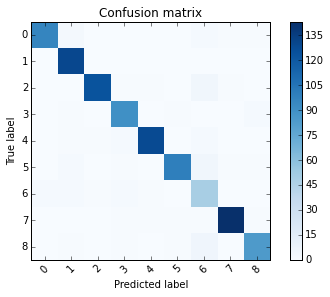

In [54]:
# Confusion matrix of SVC on Plan1
# 새로운 200개의 이미지를 test 데이터로 만들자.
p = "./data_test"
md5list = glob(os.path.join(p, "*.png"))
md5list = [os.path.split(fname)[1] for fname in md5list]
print "the number of files is %s" %len(md5list)

features = []
lables = []

t0 = time()

# captcha를 preprossing후 mnist처럼 numpy array로 만들자
for fname in md5list:
    lable = os.path.split(fname)[1].split("_")[1][:5]
    im = io.imread(os.path.join(p, fname))
    w, h, _ = im.shape

    for x in range(w):
        for j in range(h):

            if im[x][j][0] == im[x][j][1] and im[x][j][1] == im[x][j][2] and im[x][j][2] == im[x][j][0]:
                im[x][j][0] = 255
                im[x][j][1] = 255
                im[x][j][2] = 255

    im_gray = rgb2gray(im)
    im_gray = img_as_ubyte(im_gray)
    im_gray = morphology.opening(im_gray, square(2))
    im_gray_equalize = exposure.equalize_hist(im_gray)

    threshold = filters.threshold_otsu(im_gray_equalize).copy()
    threshold = im_gray_equalize < threshold
    threshold = img_as_ubyte(threshold)

    bw = morphology.closing(im_gray_equalize < threshold, square(3))
    cleared = bw.copy()

    im_th = cleared
    ctrs, hier = cv2.findContours(img_as_ubyte(im_th.copy()), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    rects = [cv2.boundingRect(ctr) for ctr in ctrs]
    rects = sorted(rects, key=lambda tup: tup[0])

    if len(rects) != 5:
        continue


    for rect, l in zip(rects, lable):
        # Draw the rectangles
        cv2.rectangle(threshold, (rect[0], rect[1]), (rect[0] + rect[2], rect[1] + rect[3]), (0, 255, 0), 1) 

        # Make the rectangular region around the digit
        roi = threshold[rect[1]:rect[1]+rect[3], rect[0]:rect[0]+rect[2]]
        roi = cv2.resize(roi, (28, 28), interpolation=cv2.INTER_AREA)
        roi = morphology.closing(roi, square(4))
        
        features.append(roi.ravel())
        lables.append([l])

features = np.array(features, 'int16')
labels = np.array(lables, 'int').ravel()

# features, lables의 차원을 출력
print features.shape
print labels.shape
print "escape time : ", round(time()-t0, 3), "s"

t0 = time()
list_hog_fd = []
for feature in features:
    fd = hog(feature.reshape((28, 28)), orientations=9, pixels_per_cell=(14, 14), cells_per_block=(1, 1), visualise=False)
    list_hog_fd.append(fd)
hog_features = np.array(list_hog_fd, 'float64')
print "escape time : ", round(time()-t0, 3), "s"

clf = joblib.load("./pkl/hog/skt/digits_SVC.pkl")

# Compute confusion matrix
cm = confusion_matrix(labels, clf.predict(hog_features))
np.set_printoptions(precision=2)
print('Confusion matrix, without normalization')
print(cm)
plt.figure()
plot_confusion_matrix(cm, labels=labels)

# Normalize the confusion matrix by row (i.e by the number of samples
# in each class)
# cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
# print('Normalized confusion matrix')
# print(cm_normalized)
# plt.figure()
# plot_confusion_matrix(cm_normalized, title='Normalized confusion matrix', labels=labels)

the number of files is 200
(1000, 784)
(1000,)
escape time :  13.174 s
escape time :  0.874 s
Confusion matrix, without normalization
[[ 96   0   0   0   0   0   0   4   3]
 [  0  80   0   0   2   0   0  48   0]
 [  0   0 103  17   1   1   0   4   6]
 [  0   0   0  76   1  12   0   3   2]
 [  0   4   2   0 124   0   1   2   1]
 [  8   0   2   5   1  83   0   2   8]
 [ 25   0   2   0   2   4   1   3  20]
 [  1   1   0   0   0   2   0 143   1]
 [ 44   0   0   0   0  17  10   3  19]]


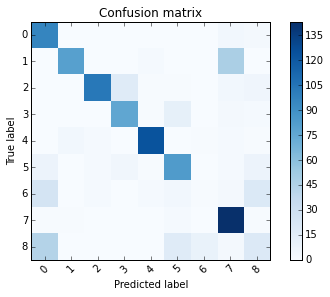

In [56]:
# Confusion matrix of KNeighbors on Plan3

# 새로운 200개의 이미지를 test 데이터로 만들자.
p = "./data_test"
md5list = glob(os.path.join(p, "*.png"))
md5list = [os.path.split(fname)[1] for fname in md5list]
print "the number of files is %s" %len(md5list)

features = []
lables = []

t0 = time()

# captcha를 preprossing후 mnist처럼 numpy array로 만들자
for fname in md5list:
    lable = os.path.split(fname)[1].split("_")[1][:5]
    im = io.imread(os.path.join(p, fname))
    w, h, _ = im.shape

    for x in range(w):
        for j in range(h):

            if im[x][j][0] == im[x][j][1] and im[x][j][1] == im[x][j][2] and im[x][j][2] == im[x][j][0]:
                im[x][j][0] = 255
                im[x][j][1] = 255
                im[x][j][2] = 255

    im_gray = rgb2gray(im)
    im_gray = img_as_ubyte(im_gray)
    im_gray = morphology.opening(im_gray, square(2))
    im_gray_equalize = exposure.equalize_hist(im_gray)

    threshold = filters.threshold_otsu(im_gray_equalize).copy()
    threshold = im_gray_equalize < threshold
    threshold = img_as_ubyte(threshold)

    bw = morphology.closing(im_gray_equalize < threshold, square(3))
    cleared = bw.copy()

    im_th = cleared
    ctrs, hier = cv2.findContours(img_as_ubyte(im_th.copy()), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    rects = [cv2.boundingRect(ctr) for ctr in ctrs]
    rects = sorted(rects, key=lambda tup: tup[0])

    if len(rects) != 5:
        continue


    for rect, l in zip(rects, lable):
        # Draw the rectangles
        cv2.rectangle(threshold, (rect[0], rect[1]), (rect[0] + rect[2], rect[1] + rect[3]), (0, 255, 0), 1) 

        # Make the rectangular region around the digit
        roi = threshold[rect[1]:rect[1]+rect[3], rect[0]:rect[0]+rect[2]]
        roi = cv2.resize(roi, (28, 28), interpolation=cv2.INTER_AREA)
        roi = morphology.closing(roi, square(4))
        
        features.append(roi.ravel())
        lables.append([l])

features = np.array(features, 'int16')
labels = np.array(lables, 'int').ravel()

# features, lables의 차원을 출력
print features.shape
print labels.shape
print "escape time : ", round(time()-t0, 3), "s"

t0 = time()
list_hog_fd = []
for feature in features:
    fd = hog(feature.reshape((28, 28)), orientations=9, pixels_per_cell=(14, 14), cells_per_block=(1, 1), visualise=False)
    list_hog_fd.append(fd)
hog_features = np.array(list_hog_fd, 'float64')
print "escape time : ", round(time()-t0, 3), "s"

clf = joblib.load("./pkl/hog/mnist/digits_KNeighborsClassifier.pkl")

# Compute confusion matrix
cm = confusion_matrix(labels, clf.predict(hog_features))
np.set_printoptions(precision=2)
print('Confusion matrix, without normalization')
print(cm)
plt.figure()
plot_confusion_matrix(cm, labels=labels)